# Set Parameter
- Drop out = 0.2
- Hidden unit = 50
- Epochs = 100

# Import packages

import useful packages for experiments

In [1]:
import os
import argparse
import logging

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

from trainer.supervised_trainer import SupervisedTrainer
from models.encoderRNN import EncoderRNN
from models.decoderRNN import DecoderRNN
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from optim.optim import Optimizer
from dataset import fields
from evaluator.predictor import Predictor

import matplotlib.pyplot as plt

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))
/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


# Log format

In [2]:
log_level = 'info'
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

# Data load

In [3]:
train_path = "data/bracket_rand/N100/data_train.txt"
dev_path = "data/bracket_rand/N100/data_test.txt"

# Pretrain - Data load

In [4]:
pretrain_train_path = "data/bracket_rand/N50/data_train.txt"
pretrain_dev_path = "data/bracket_rand/N50/data_test.txt"

# Prepare dataset

In [5]:
src = fields.SourceField()
tgt = fields.TargetField()
max_len = 104
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
train = torchtext.data.TabularDataset(
    path=train_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
dev = torchtext.data.TabularDataset(
    path=dev_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
src.build_vocab(train)
tgt.build_vocab(train)
input_vocab = src.vocab
output_vocab = tgt.vocab

# Pretrain - Prepare dataset

In [6]:
pretrain_src = fields.SourceField()
pretrain_tgt = fields.TargetField()
max_len = 104
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
pretrain_train = torchtext.data.TabularDataset(
    path=pretrain_train_path, format='tsv',
    fields=[('src', pretrain_src), ('tgt', pretrain_tgt)],
    filter_pred=len_filter
)
pretrain_dev = torchtext.data.TabularDataset(
    path=pretrain_dev_path, format='tsv',
    fields=[('src', pretrain_src), ('tgt', pretrain_tgt)],
    filter_pred=len_filter
)
pretrain_src.build_vocab(pretrain_train)
pretrain_tgt.build_vocab(pretrain_train)
pretrain_input_vocab = pretrain_src.vocab
pretrain_output_vocab = pretrain_tgt.vocab

# Prepare loss

In [7]:
weight = torch.ones(len(tgt.vocab))
pad = tgt.vocab.stoi[tgt.pad_token]
loss = Perplexity(weight, pad)
if torch.cuda.is_available():
    loss.cuda()

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Pretrain - Prepare loss

In [8]:
pretrain_weight = torch.ones(len(pretrain_tgt.vocab))
pretrain_pad = pretrain_tgt.vocab.stoi[pretrain_tgt.pad_token]
pretrain_loss = Perplexity(pretrain_weight, pretrain_pad)
if torch.cuda.is_available():
    pretrain_loss.cuda()

# Variable definition

In [9]:
optimizer = "Adam"
hidden_size = 50
bidirectional = True

# Initialize model
- Attention = None
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
2019-02-27 01:33:15,824 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None
2019-02-27 01:34:08,192 INFO   Finished epoch 1: Train loss: 20.9199, Dev loss: 17.2519, Accuracy(Character): 0.0910, Accuracy(Word): 0.0000
2019-02-27 01:34:58,733 INFO   Finished epoch 2: Train loss: 15.7457, Dev loss: 17.1003, Accuracy(Character): 0.0971, Accuracy(Word): 0.0000
2019-02-27 01:35:46,494 INFO   Finished epoch 3: Train loss: 16.4262, Dev loss: 16.5659, Accuracy(Character): 0.1394, Accuracy(Word): 0.0000
2019-02-27 01:36:34,401 INFO   Finished epoch 4: Train loss: 12.1484, Dev loss: 12.9185, Accuracy(

2019-02-27 02:26:45,793 INFO   Finished epoch 57: Train loss: 2.3391, Dev loss: 3.1673, Accuracy(Character): 0.5491, Accuracy(Word): 0.1318
2019-02-27 02:27:47,858 INFO   Finished epoch 58: Train loss: 2.3358, Dev loss: 3.4634, Accuracy(Character): 0.5260, Accuracy(Word): 0.1052
2019-02-27 02:28:48,160 INFO   Finished epoch 59: Train loss: 2.4368, Dev loss: 3.0259, Accuracy(Character): 0.5640, Accuracy(Word): 0.1358
2019-02-27 02:29:50,456 INFO   Finished epoch 60: Train loss: 2.4782, Dev loss: 3.0053, Accuracy(Character): 0.5447, Accuracy(Word): 0.1302
2019-02-27 02:30:52,134 INFO   Finished epoch 61: Train loss: 2.2963, Dev loss: 3.6942, Accuracy(Character): 0.5235, Accuracy(Word): 0.1346
2019-02-27 02:31:51,348 INFO   Finished epoch 62: Train loss: 2.3962, Dev loss: 2.9767, Accuracy(Character): 0.5697, Accuracy(Word): 0.1364
2019-02-27 02:32:51,178 INFO   Finished epoch 63: Train loss: 2.1660, Dev loss: 2.9614, Accuracy(Character): 0.5561, Accuracy(Word): 0.1308
2019-02-27 02:33:50,

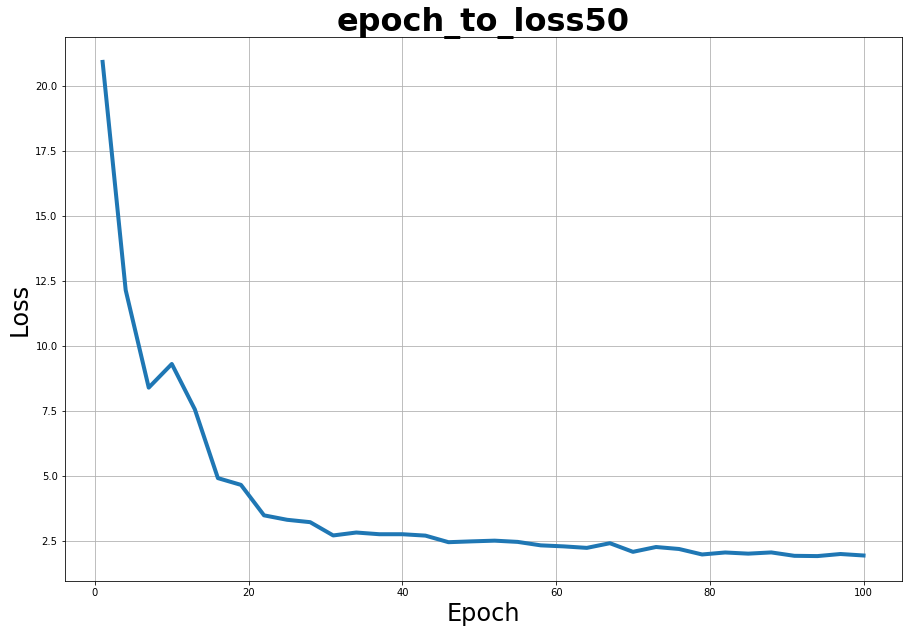

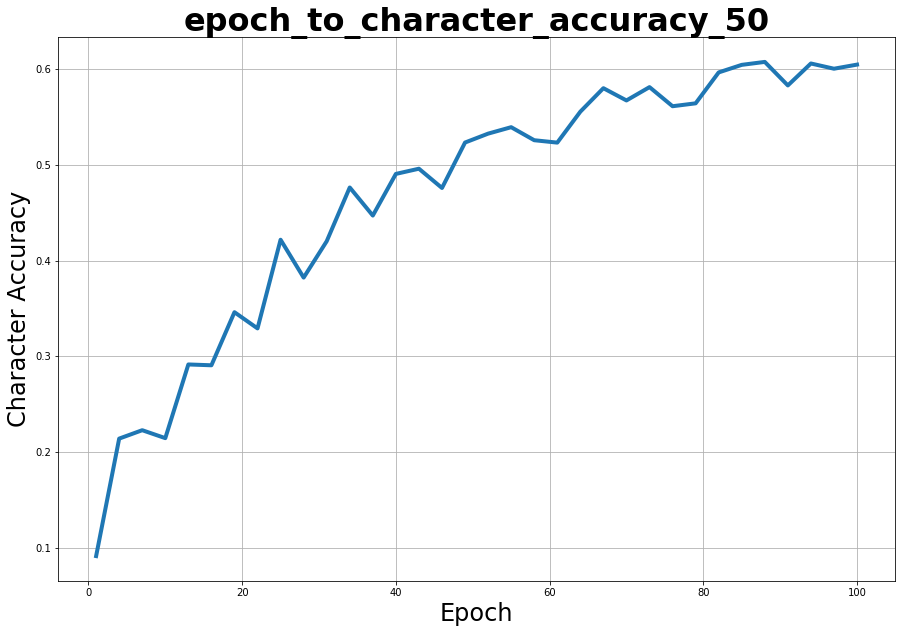

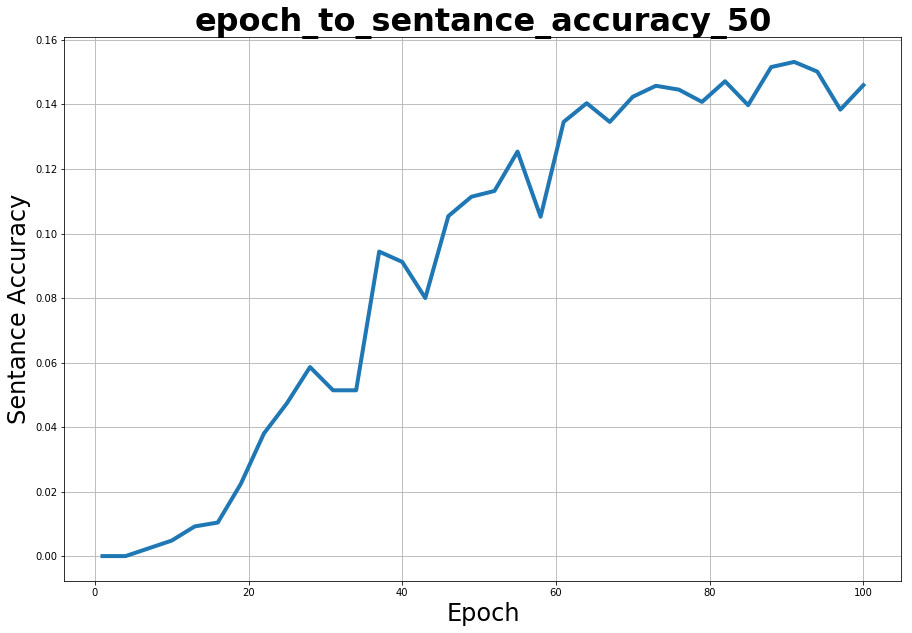

In [10]:
seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                     bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention=None, bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=32,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="standard_rand")

seq2seq, ave_loss, standard_character_accuracy_list, standard_sentance_accuracy_list = t.train(seq2seq, train,
                                                                            num_epochs=100, dev_data=dev,
                                                                            optimizer=optimizer,
                                                                            teacher_forcing_ratio=0.5)

In [11]:
torch.save(seq2seq.state_dict(), 'log/pth/standard_rand_model_save.pth')

- Attention = Bahdanau
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32

2019-02-27 03:10:11,304 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None
2019-02-27 03:11:32,988 INFO   Finished epoch 1: Train loss: 19.8172, Dev loss: 22.9205, Accuracy(Character): 0.0990, Accuracy(Word): 0.0000
2019-02-27 03:12:49,513 INFO   Finished epoch 2: Train loss: 14.3640, Dev loss: 17.6518, Accuracy(Character): 0.1065, Accuracy(Word): 0.0000
2019-02-27 03:14:09,328 INFO   Finished epoch 3: Train loss: 12.0983, Dev loss: 16.7432, Accuracy(Character): 0.1204, Accuracy(Word): 0.0000
2019-02-27 03:15:31,443 INFO   Finished epoch 4: Train loss: 10.8077, Dev loss: 15.9487, Accuracy(Character): 0.1389, Accuracy(Word): 0.0016
2019-02-27 03:16:50,125 INFO   Finished epoch 5: Train loss: 9.6638, Dev loss: 16.2073, Accuracy(Character): 0.1403, Accuracy(Word): 0.0000
2019-02-27 03:18:05,767 INFO   Finished epoch 6: Train loss: 7.3237, Dev loss: 10.7140, Accuracy(Character): 0.1837, A

2019-02-27 04:17:51,428 INFO   Finished epoch 59: Train loss: 2.2996, Dev loss: 3.3152, Accuracy(Character): 0.4871, Accuracy(Word): 0.1038
2019-02-27 04:18:57,891 INFO   Finished epoch 60: Train loss: 2.3881, Dev loss: 3.3357, Accuracy(Character): 0.4776, Accuracy(Word): 0.1000
2019-02-27 04:20:09,320 INFO   Finished epoch 61: Train loss: 2.4418, Dev loss: 3.3642, Accuracy(Character): 0.4851, Accuracy(Word): 0.0976
2019-02-27 04:21:16,658 INFO   Finished epoch 62: Train loss: 2.2255, Dev loss: 3.4558, Accuracy(Character): 0.4628, Accuracy(Word): 0.1058
2019-02-27 04:22:24,680 INFO   Finished epoch 63: Train loss: 2.5638, Dev loss: 3.4323, Accuracy(Character): 0.4689, Accuracy(Word): 0.0740
2019-02-27 04:23:30,476 INFO   Finished epoch 64: Train loss: 2.4038, Dev loss: 3.2123, Accuracy(Character): 0.5002, Accuracy(Word): 0.0864
2019-02-27 04:24:39,937 INFO   Finished epoch 65: Train loss: 2.5911, Dev loss: 3.7657, Accuracy(Character): 0.4487, Accuracy(Word): 0.1078
2019-02-27 04:25:47,

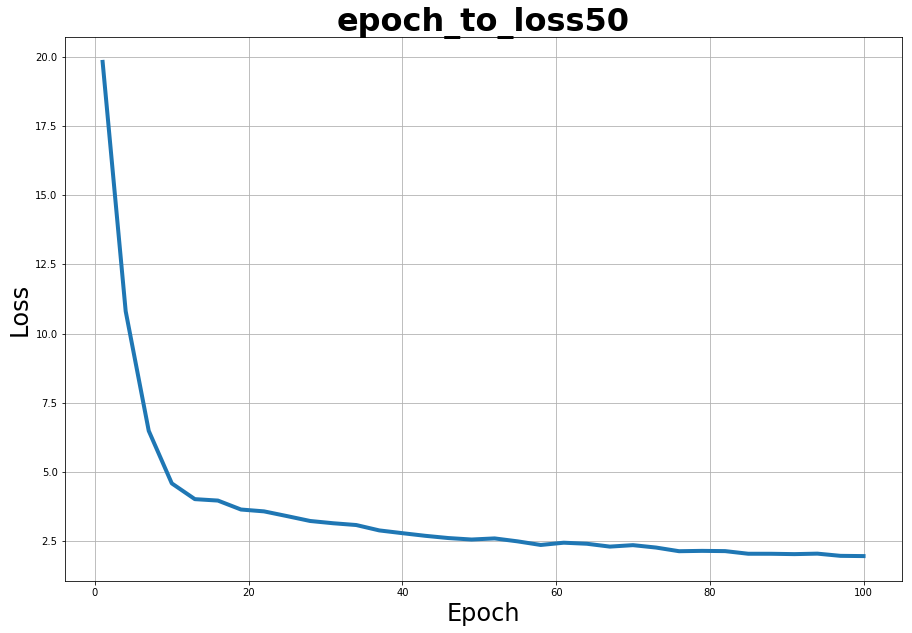

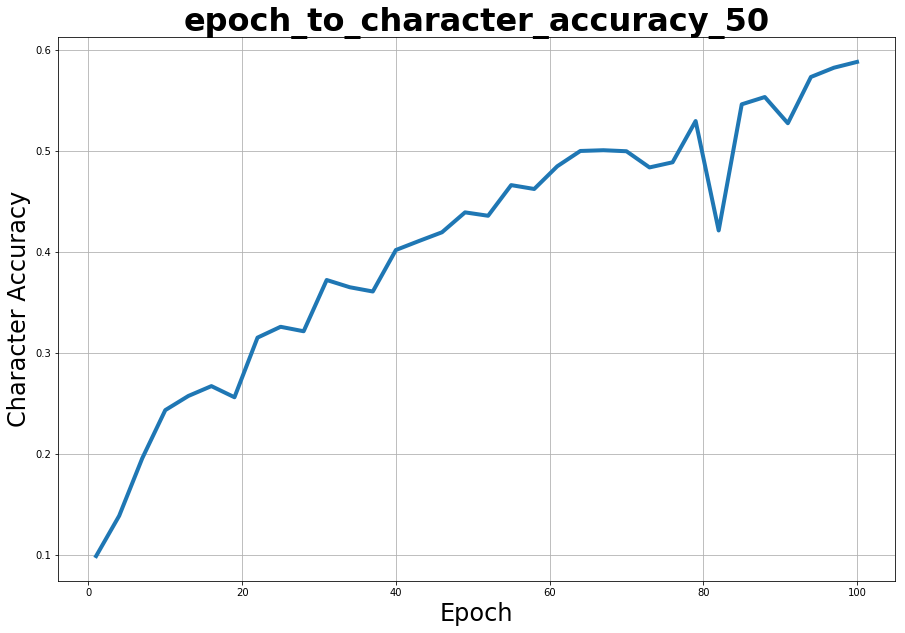

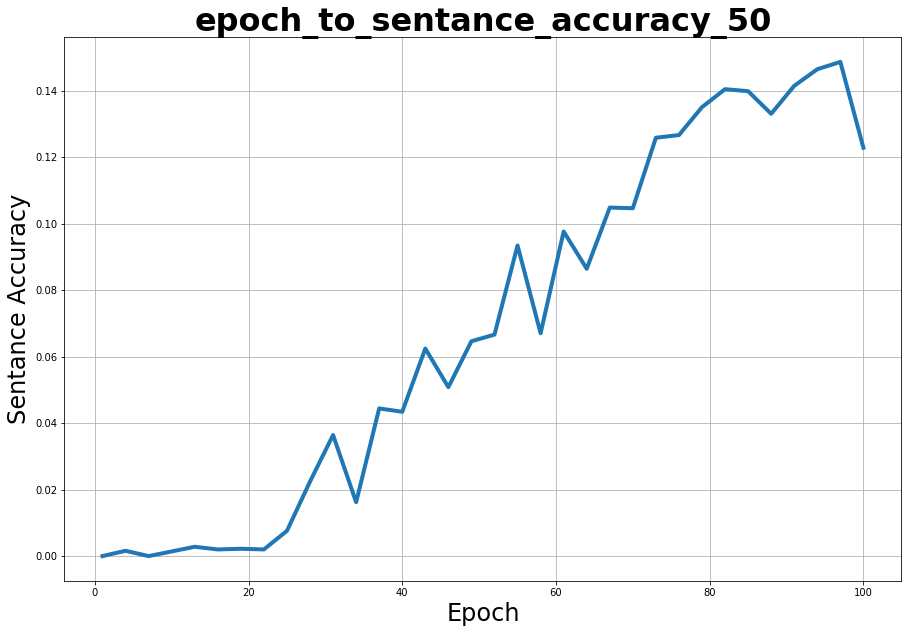

In [12]:
seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                     bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention="Bahdanau", bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=32,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="Bahdanau_att_rand")

seq2seq, ave_loss, bahdanau_att_character_accuracy_list, bahdanau_att_sentance_accuracy_list = t.train(seq2seq, train,
                                                                            num_epochs=100, dev_data=dev,
                                                                            optimizer=optimizer,
                                                                            teacher_forcing_ratio=0.5)

In [13]:
torch.save(seq2seq.state_dict(), 'log/pth/Bahdanau_att_rand_model_save.pth')

- Attention = Luong
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32

2019-02-27 14:50:48,926 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None
/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
2019-02-27 14:52:11,834 INFO   Finished epoch 1: Train loss: 20.7297, Dev loss: 17.5961, Accuracy(Character): 0.0976, Accuracy(Word): 0.0000
2019-02-27 14:53:35,805 INFO   Finished epoch 2: Train loss: 16.0053, Dev loss: 16.6082, Accuracy(Character): 0.1011, Accuracy(Word): 0.0000
2019-02-27 14:54:57,252 INFO   Finished epoch 3: Train loss: 13.9559, Dev loss: 17.5246, Accuracy(Character): 0.1029, Accuracy(Word): 0.0000
2019-02-27 14:56:23,790 INFO   Finished epoch 4: Train loss: 15.4727, Dev loss: 23.4241, Accuracy(Character): 0.1185, Accuracy(Word): 0.0000
2019-02-27 14:57:50,843 I

2019-02-27 16:18:52,653 INFO   Finished epoch 57: Train loss: 1.6744, Dev loss: 1.9523, Accuracy(Character): 0.7615, Accuracy(Word): 0.2218
2019-02-27 16:20:26,152 INFO   Finished epoch 58: Train loss: 1.7054, Dev loss: 2.0515, Accuracy(Character): 0.7408, Accuracy(Word): 0.2248
2019-02-27 16:22:00,533 INFO   Finished epoch 59: Train loss: 1.7172, Dev loss: 1.8751, Accuracy(Character): 0.7674, Accuracy(Word): 0.2266
2019-02-27 16:23:36,091 INFO   Finished epoch 60: Train loss: 1.5008, Dev loss: 1.9159, Accuracy(Character): 0.7644, Accuracy(Word): 0.2440
2019-02-27 16:25:16,408 INFO   Finished epoch 61: Train loss: 1.6657, Dev loss: 2.0112, Accuracy(Character): 0.7394, Accuracy(Word): 0.2120
2019-02-27 16:26:48,982 INFO   Finished epoch 62: Train loss: 1.4928, Dev loss: 2.1969, Accuracy(Character): 0.7156, Accuracy(Word): 0.2486
2019-02-27 16:28:32,207 INFO   Finished epoch 63: Train loss: 1.6333, Dev loss: 2.2866, Accuracy(Character): 0.6945, Accuracy(Word): 0.1942
2019-02-27 16:30:09,

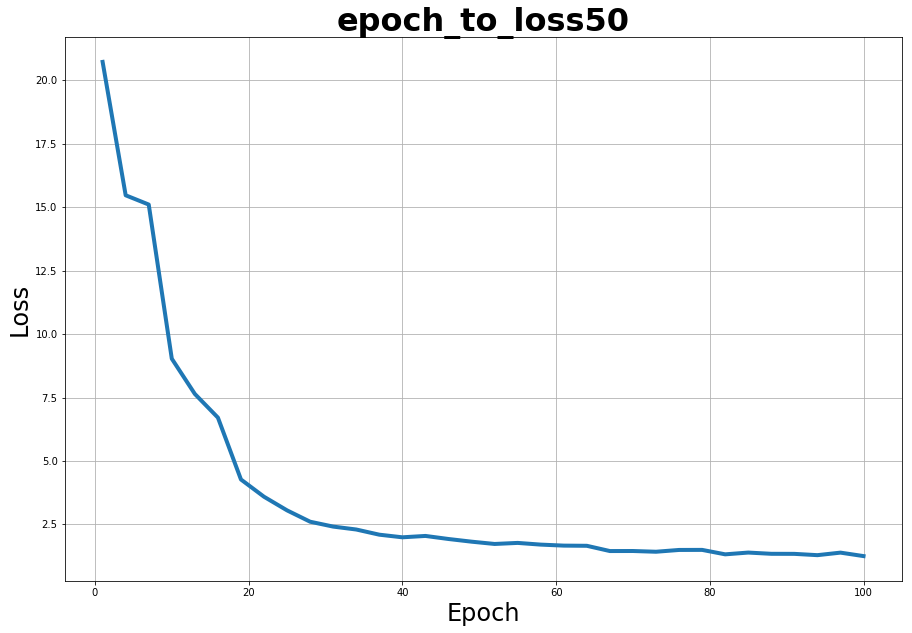

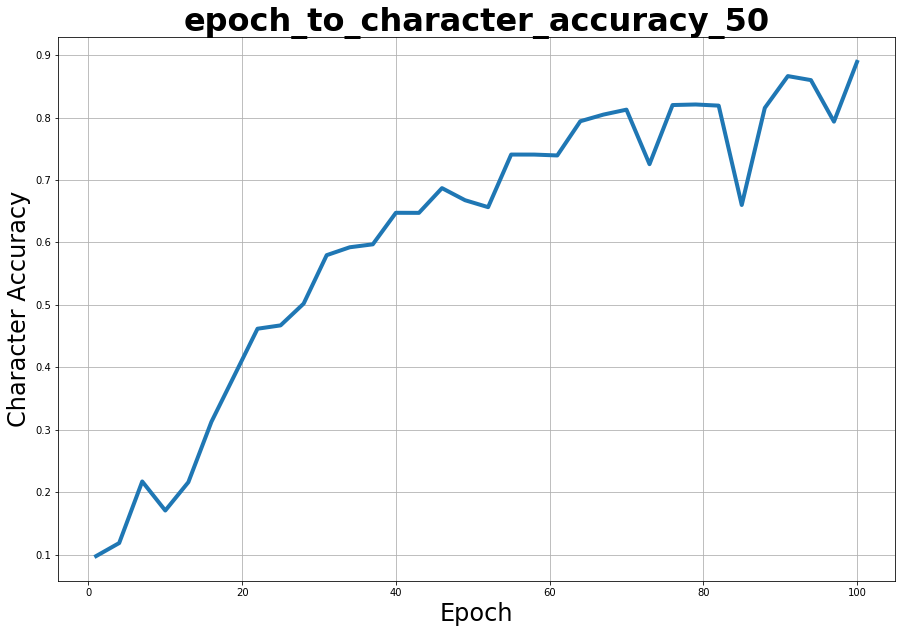

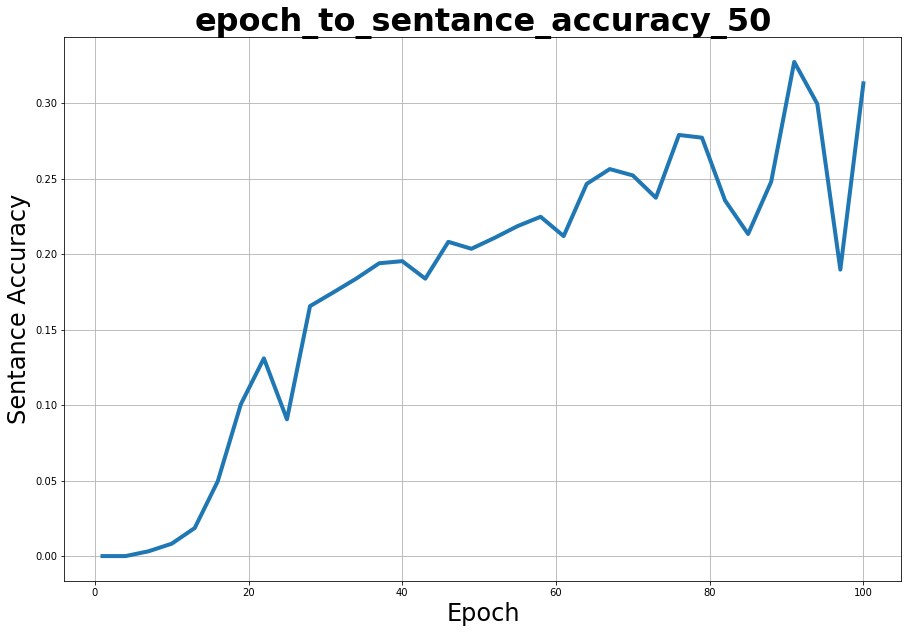

In [33]:
seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                     bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention="Luong", bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=32,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="Luong_att_rand")

seq2seq, ave_loss, luong_att_character_accuracy_list, luong_att_sentance_accuracy_list = t.train(seq2seq, train,
                                                                            num_epochs=100, dev_data=dev,
                                                                            optimizer=optimizer,
                                                                            teacher_forcing_ratio=0.5)

In [34]:
torch.save(seq2seq.state_dict(), 'log/pth/Luong_att_rand_model_save.pth')

- Attention = None
- Teacher Forcing Ratio = 1
- Layer = 1
- Batch size = 32

2019-02-27 06:25:59,550 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None
2019-02-27 06:26:43,257 INFO   Finished epoch 1: Train loss: 21.0168, Dev loss: 17.4854, Accuracy(Character): 0.1062, Accuracy(Word): 0.0000
2019-02-27 06:27:26,278 INFO   Finished epoch 2: Train loss: 11.5429, Dev loss: 33.7263, Accuracy(Character): 0.1111, Accuracy(Word): 0.0000
2019-02-27 06:28:07,939 INFO   Finished epoch 3: Train loss: 5.1288, Dev loss: 45.4121, Accuracy(Character): 0.1923, Accuracy(Word): 0.0000
2019-02-27 06:28:51,772 INFO   Finished epoch 4: Train loss: 2.8123, Dev loss: 37.2440, Accuracy(Character): 0.1954, Accuracy(Word): 0.0000
2019-02-27 06:29:37,161 INFO   Finished epoch 5: Train loss: 2.2000, Dev loss: 114.8139, Accuracy(Character): 0.1372, Accuracy(Word): 0.0034
2019-02-27 06:30:21,186 INFO   Finished epoch 6: Train loss: 1.9841, Dev loss: 204.9293, Accuracy(Character): 0.1618, A

2019-02-27 07:06:04,340 INFO   Finished epoch 58: Train loss: 1.5033, Dev loss: 57.7135, Accuracy(Character): 0.4405, Accuracy(Word): 0.1094
2019-02-27 07:06:39,438 INFO   Finished epoch 59: Train loss: 1.4967, Dev loss: 53.6208, Accuracy(Character): 0.4464, Accuracy(Word): 0.1320
2019-02-27 07:07:14,682 INFO   Finished epoch 60: Train loss: 1.4929, Dev loss: 22.9941, Accuracy(Character): 0.4926, Accuracy(Word): 0.1388
2019-02-27 07:07:49,128 INFO   Finished epoch 61: Train loss: 1.4923, Dev loss: 44.1219, Accuracy(Character): 0.4589, Accuracy(Word): 0.1354
2019-02-27 07:08:23,398 INFO   Finished epoch 62: Train loss: 1.4915, Dev loss: 34.6208, Accuracy(Character): 0.4673, Accuracy(Word): 0.0776
2019-02-27 07:08:57,765 INFO   Finished epoch 63: Train loss: 1.4903, Dev loss: 40.1749, Accuracy(Character): 0.4510, Accuracy(Word): 0.1178
2019-02-27 07:09:32,748 INFO   Finished epoch 64: Train loss: 1.4826, Dev loss: 34.3038, Accuracy(Character): 0.4674, Accuracy(Word): 0.1398
2019-02-27 07

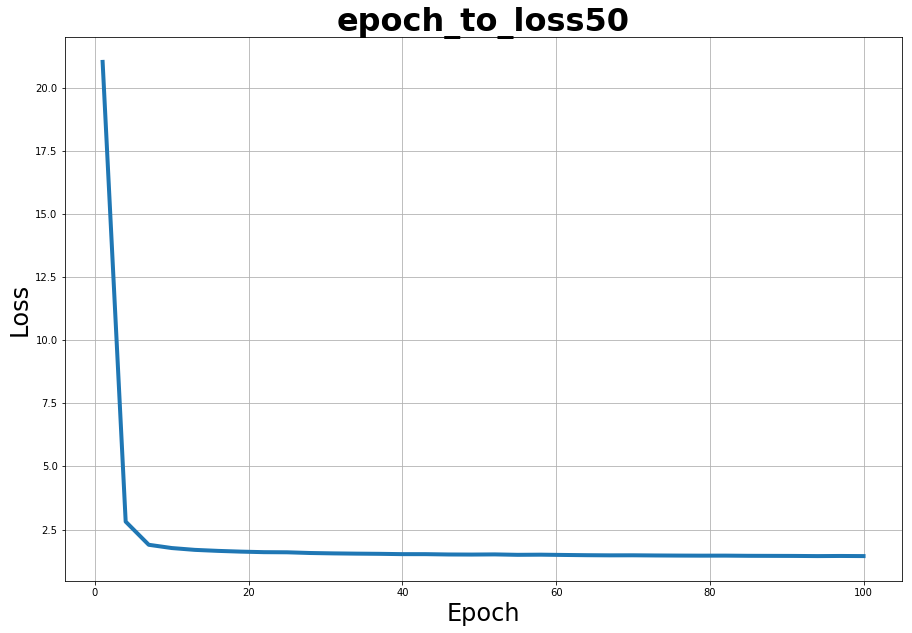

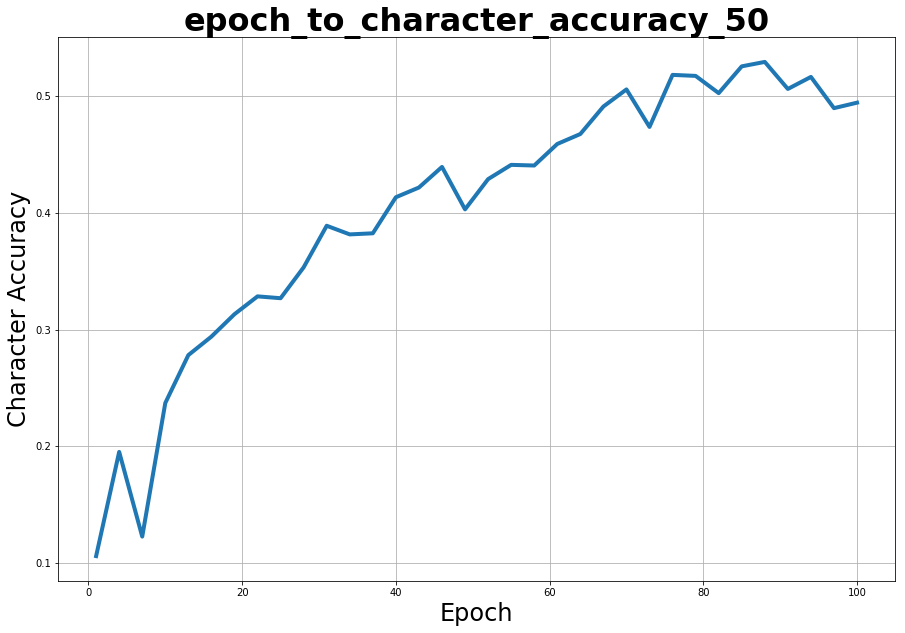

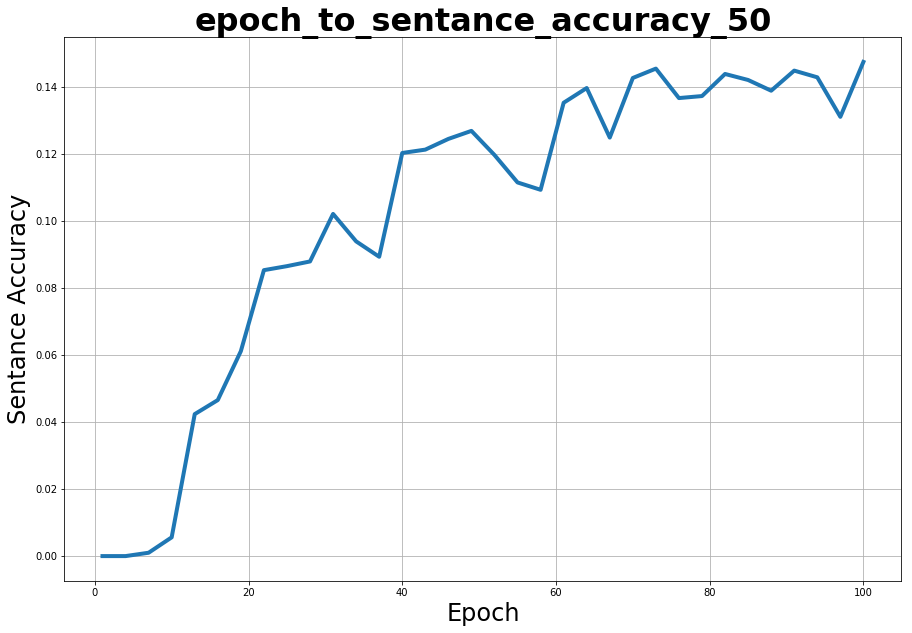

In [ ]:
seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                     bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention=None, bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=32,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="Teacher_Forcing_Ratio_1_rand")

seq2seq, ave_loss, tfr_character_accuracy_list, tfr_sentance_accuracy_list = t.train(seq2seq, train,
                                                                            num_epochs=100, dev_data=dev,
                                                                            optimizer=optimizer,
                                                                            teacher_forcing_ratio=1)

In [ ]:
torch.save(seq2seq.state_dict(), 'log/pth/Teacher_Forcing_Ratio_1_rand_model_save.pth')

- Attention = None
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 64

In [ ]:
seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                     bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention=None, bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=64,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="batch_size_64_rand")

seq2seq, ave_loss, batch_size_64_character_accuracy_list, batch_size_64_sentance_accuracy_list = t.train(seq2seq, train,
                                                                            num_epochs=100, dev_data=dev,
                                                                            optimizer=optimizer,
                                                                            teacher_forcing_ratio=0.5)

2019-02-27 07:30:38,252 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None
2019-02-27 07:30:59,548 INFO   Finished epoch 1: Train loss: 23.9297, Dev loss: 18.9916, Accuracy(Character): 0.0876, Accuracy(Word): 0.0000
2019-02-27 07:31:18,514 INFO   Finished epoch 2: Train loss: 16.9007, Dev loss: 17.7630, Accuracy(Character): 0.1024, Accuracy(Word): 0.0000
2019-02-27 07:31:40,361 INFO   Finished epoch 3: Train loss: 16.3669, Dev loss: 17.0610, Accuracy(Character): 0.1027, Accuracy(Word): 0.0000
2019-02-27 07:31:58,731 INFO   Finished epoch 4: Train loss: 15.6294, Dev loss: 17.5150, Accuracy(Character): 0.1210, Accuracy(Word): 0.0000
2019-02-27 07:32:20,665 INFO   Finished epoch 5: Train loss: 16.3357, Dev loss: 17.7090, Accuracy(Character): 0.1110, Accuracy(Word): 0.0000
2019-02-27 07:32:39,805 INFO   Finished epoch 6: Train loss: 15.1917, Dev loss: 18.6512, Accuracy(Character): 0.1119,

2019-02-27 07:47:01,085 INFO   Finished epoch 59: Train loss: 3.0465, Dev loss: 5.1332, Accuracy(Character): 0.4594, Accuracy(Word): 0.1224
2019-02-27 07:47:17,738 INFO   Finished epoch 60: Train loss: 2.8288, Dev loss: 5.3465, Accuracy(Character): 0.4149, Accuracy(Word): 0.1174
2019-02-27 07:47:33,804 INFO   Finished epoch 61: Train loss: 2.7573, Dev loss: 3.8253, Accuracy(Character): 0.4890, Accuracy(Word): 0.1240
2019-02-27 07:47:50,408 INFO   Finished epoch 62: Train loss: 2.6164, Dev loss: 3.6910, Accuracy(Character): 0.5020, Accuracy(Word): 0.1156
2019-02-27 07:48:06,285 INFO   Finished epoch 63: Train loss: 2.6713, Dev loss: 3.6914, Accuracy(Character): 0.4945, Accuracy(Word): 0.1174
2019-02-27 07:48:22,671 INFO   Finished epoch 64: Train loss: 2.8080, Dev loss: 3.8703, Accuracy(Character): 0.4868, Accuracy(Word): 0.1122
2019-02-27 07:48:38,970 INFO   Finished epoch 65: Train loss: 2.7806, Dev loss: 3.3926, Accuracy(Character): 0.4970, Accuracy(Word): 0.1272
2019-02-27 07:48:56,

In [25]:
torch.save(seq2seq.state_dict(), 'log/pth/batch_size_64_rand_model_save.pth')

- Attention = None
- Teacher Forcing Ratio = 0.5
- Layer = 2
- Batch size = 32

2019-02-27 09:51:04,840 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None
2019-02-27 09:51:27,715 INFO   Finished epoch 1: Train loss: 20.0363, Dev loss: 17.5163, Accuracy(Character): 0.1057, Accuracy(Word): 0.0000
2019-02-27 09:51:55,856 INFO   Finished epoch 2: Train loss: 16.1718, Dev loss: 16.8415, Accuracy(Character): 0.1188, Accuracy(Word): 0.0000
2019-02-27 09:52:24,097 INFO   Finished epoch 3: Train loss: 15.0736, Dev loss: 14.7659, Accuracy(Character): 0.1463, Accuracy(Word): 0.0000
2019-02-27 09:52:52,162 INFO   Finished epoch 4: Train loss: 12.5775, Dev loss: 11.5338, Accuracy(Character): 0.1836, Accuracy(Word): 0.0000
2019-02-27 09:53:22,567 INFO   Finished epoch 5: Train loss: 9.3749, Dev loss: 9.1951, Accuracy(Character): 0.2815, Accuracy(Word): 0.0000
2019-02-27 09:53:50,933 INFO   Finished epoch 6: Train loss: 5.9829, Dev loss: 5.3556, Accuracy(Character): 0.3950, Acc

2019-02-27 10:22:06,002 INFO   Finished epoch 59: Train loss: 1.7354, Dev loss: 2.1079, Accuracy(Character): 0.6822, Accuracy(Word): 0.1678
2019-02-27 10:22:41,856 INFO   Finished epoch 60: Train loss: 1.8292, Dev loss: 2.5197, Accuracy(Character): 0.6233, Accuracy(Word): 0.1494
2019-02-27 10:23:15,799 INFO   Finished epoch 61: Train loss: 1.6879, Dev loss: 2.0745, Accuracy(Character): 0.6948, Accuracy(Word): 0.1570
2019-02-27 10:23:51,174 INFO   Finished epoch 62: Train loss: 1.7683, Dev loss: 2.3825, Accuracy(Character): 0.6585, Accuracy(Word): 0.1228
2019-02-27 10:24:26,357 INFO   Finished epoch 63: Train loss: 1.7413, Dev loss: 2.0437, Accuracy(Character): 0.7040, Accuracy(Word): 0.1646
2019-02-27 10:25:01,306 INFO   Finished epoch 64: Train loss: 1.6984, Dev loss: 2.0919, Accuracy(Character): 0.6918, Accuracy(Word): 0.1632
2019-02-27 10:25:35,632 INFO   Finished epoch 65: Train loss: 1.6881, Dev loss: 2.1362, Accuracy(Character): 0.6764, Accuracy(Word): 0.1622
2019-02-27 10:26:10,

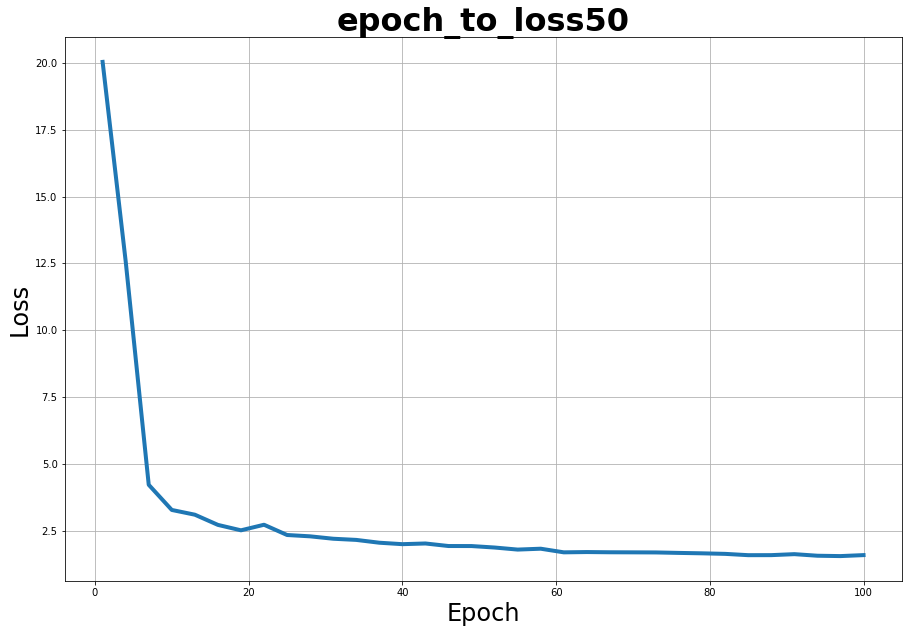

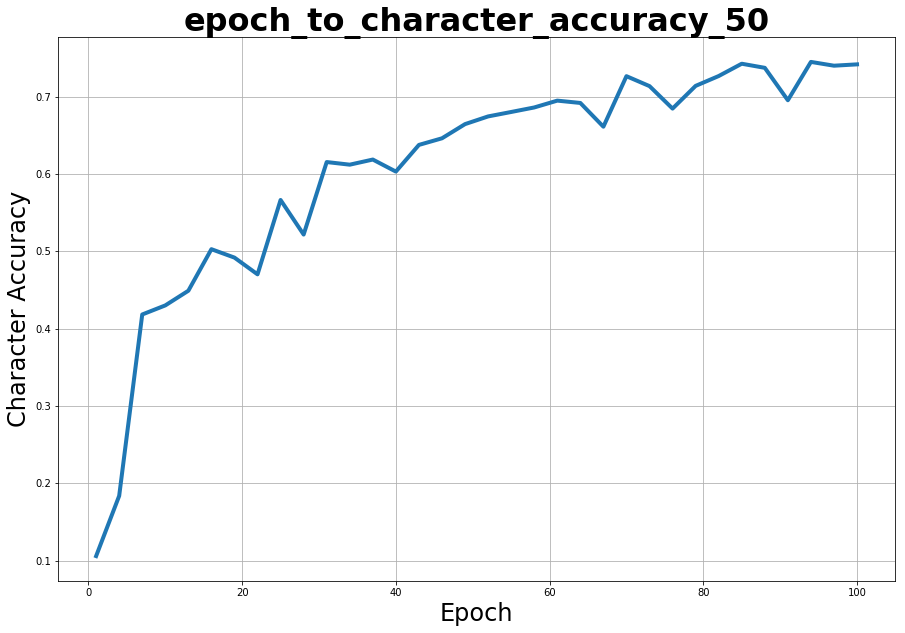

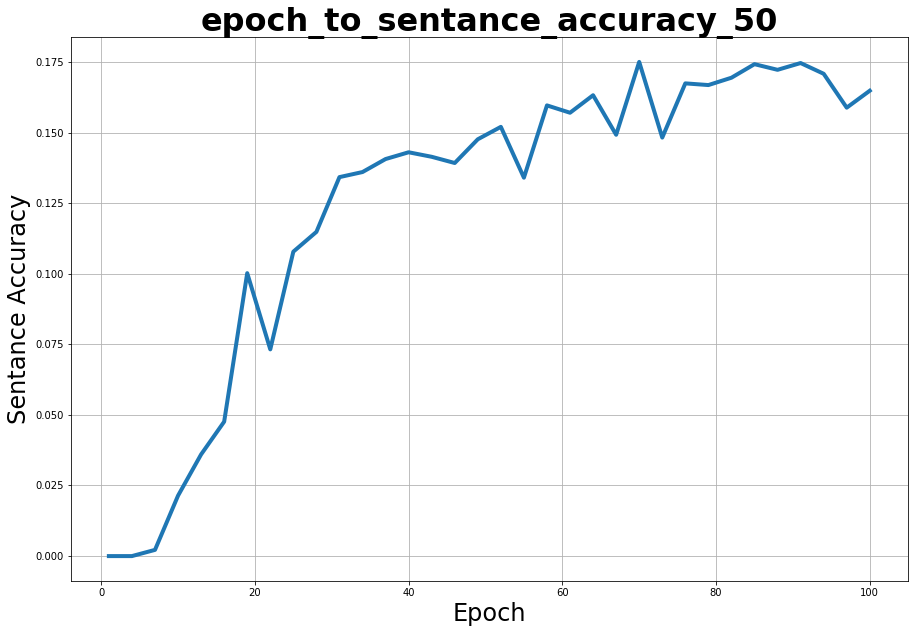

In [26]:
seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size, n_layers=2,
                     bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, n_layers=2, use_attention=None, bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=32,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="two_layer_rand")

seq2seq, ave_loss, two_layer_character_accuracy_list, two_layer_sentance_accuracy_list = t.train(seq2seq, train,
                                                                            num_epochs=100, dev_data=dev,
                                                                            optimizer=optimizer,
                                                                            teacher_forcing_ratio=0.5)

In [35]:
torch.save(seq2seq.state_dict(), 'log/pth/two_layer_rand_model_save.pth')

- Attention = None
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32
- Pretrained

2019-02-27 17:28:34,850 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


pretrain..


2019-02-27 17:29:23,619 INFO   Finished epoch 1: Train loss: 15.1397, Dev loss: 11.1446, Accuracy(Character): 0.1592, Accuracy(Word): 0.0000
2019-02-27 17:30:07,567 INFO   Finished epoch 2: Train loss: 10.4176, Dev loss: 10.0796, Accuracy(Character): 0.2666, Accuracy(Word): 0.0000
2019-02-27 17:30:54,490 INFO   Finished epoch 3: Train loss: 5.9053, Dev loss: 5.2196, Accuracy(Character): 0.3619, Accuracy(Word): 0.0000
2019-02-27 17:31:44,114 INFO   Finished epoch 4: Train loss: 4.2766, Dev loss: 4.4871, Accuracy(Character): 0.3822, Accuracy(Word): 0.0000
2019-02-27 17:32:29,631 INFO   Finished epoch 5: Train loss: 3.6286, Dev loss: 4.2260, Accuracy(Character): 0.4336, Accuracy(Word): 0.0060
2019-02-27 17:33:13,565 INFO   Finished epoch 6: Train loss: 3.3568, Dev loss: 4.2396, Accuracy(Character): 0.4212, Accuracy(Word): 0.0016
2019-02-27 17:34:00,228 INFO   Finished epoch 7: Train loss: 3.3038, Dev loss: 4.5426, Accuracy(Character): 0.4029, Accuracy(Word): 0.0026
2019-02-27 17:34:43,672

train..


2019-02-27 18:08:23,993 INFO   Finished epoch 1: Train loss: 2419.6526, Dev loss: 10.7196, Accuracy(Character): 0.2088, Accuracy(Word): 0.0000
2019-02-27 18:09:41,991 INFO   Finished epoch 2: Train loss: 5.9683, Dev loss: 6.9174, Accuracy(Character): 0.3670, Accuracy(Word): 0.0312
2019-02-27 18:11:06,867 INFO   Finished epoch 3: Train loss: 3.9400, Dev loss: 4.3347, Accuracy(Character): 0.4731, Accuracy(Word): 0.0536
2019-02-27 18:12:30,773 INFO   Finished epoch 4: Train loss: 3.0199, Dev loss: 4.3388, Accuracy(Character): 0.4387, Accuracy(Word): 0.0752
2019-02-27 18:13:55,729 INFO   Finished epoch 5: Train loss: 2.7787, Dev loss: 3.5332, Accuracy(Character): 0.5103, Accuracy(Word): 0.0938
2019-02-27 18:15:23,106 INFO   Finished epoch 6: Train loss: 2.7216, Dev loss: 4.4910, Accuracy(Character): 0.4525, Accuracy(Word): 0.0992
2019-02-27 18:16:44,184 INFO   Finished epoch 7: Train loss: 2.5506, Dev loss: 3.6286, Accuracy(Character): 0.4948, Accuracy(Word): 0.1008
2019-02-27 18:18:06,732

2019-02-27 19:30:04,037 INFO   Finished epoch 60: Train loss: 1.7932, Dev loss: 2.3991, Accuracy(Character): 0.6412, Accuracy(Word): 0.1548
2019-02-27 19:31:28,539 INFO   Finished epoch 61: Train loss: 1.7896, Dev loss: 2.2023, Accuracy(Character): 0.6690, Accuracy(Word): 0.1494
2019-02-27 19:32:48,305 INFO   Finished epoch 62: Train loss: 1.7489, Dev loss: 2.2203, Accuracy(Character): 0.6731, Accuracy(Word): 0.1566
2019-02-27 19:34:09,407 INFO   Finished epoch 63: Train loss: 1.7773, Dev loss: 2.2723, Accuracy(Character): 0.6608, Accuracy(Word): 0.1580
2019-02-27 19:35:32,485 INFO   Finished epoch 64: Train loss: 1.7136, Dev loss: 2.1512, Accuracy(Character): 0.6737, Accuracy(Word): 0.1590
2019-02-27 19:36:53,372 INFO   Finished epoch 65: Train loss: 1.7018, Dev loss: 2.2082, Accuracy(Character): 0.6733, Accuracy(Word): 0.1578
2019-02-27 19:38:17,321 INFO   Finished epoch 66: Train loss: 1.7498, Dev loss: 2.3290, Accuracy(Character): 0.6416, Accuracy(Word): 0.1516
2019-02-27 19:39:37,

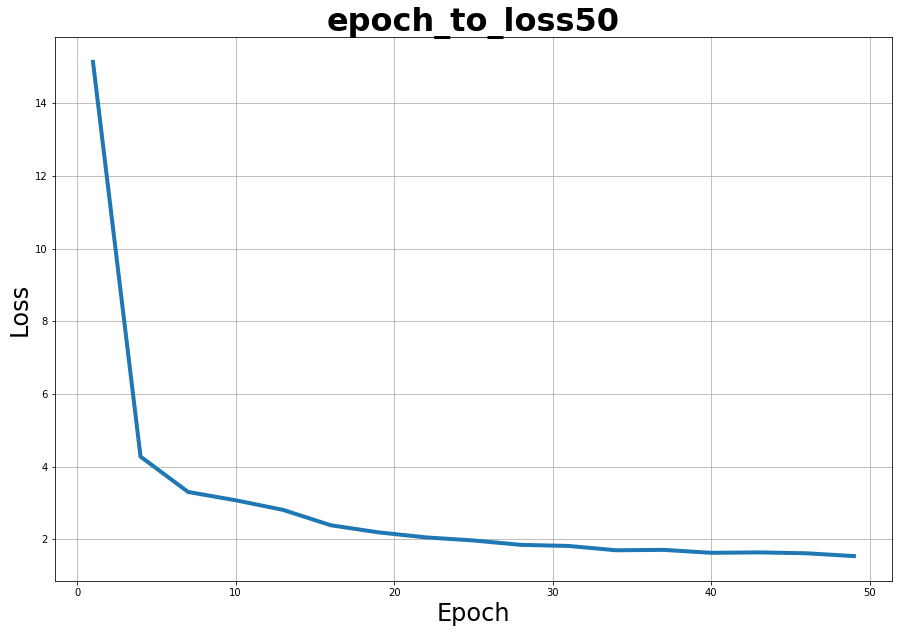

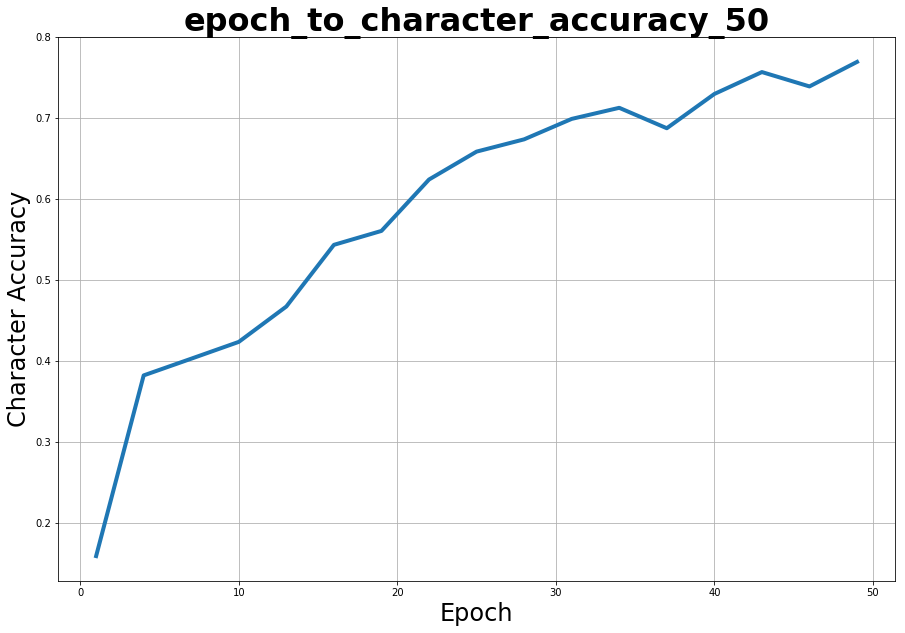

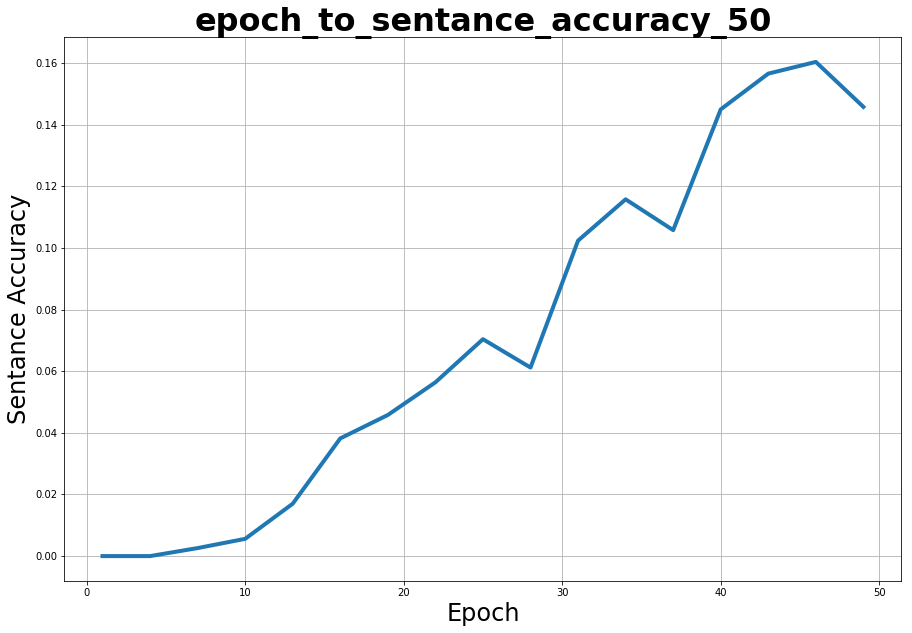

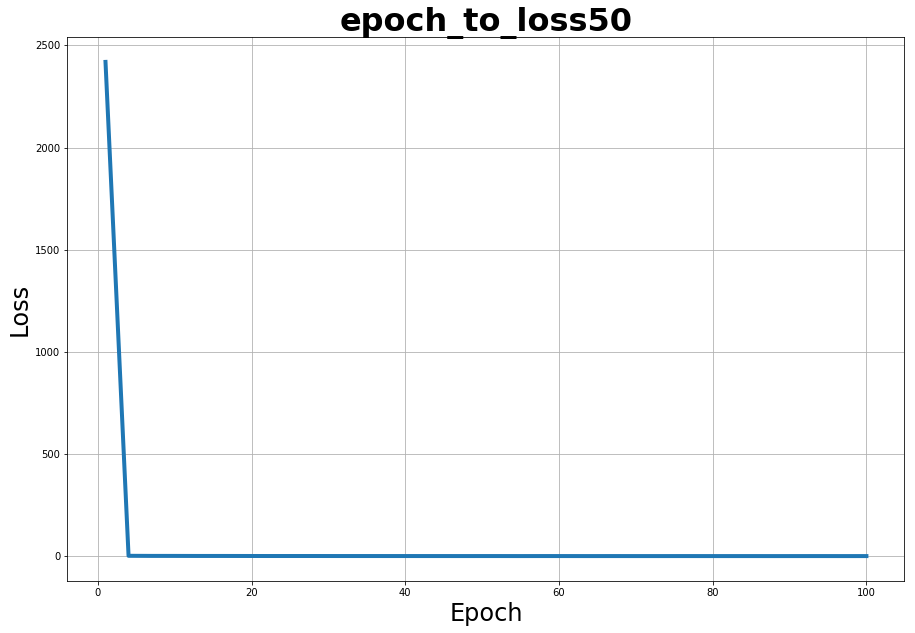

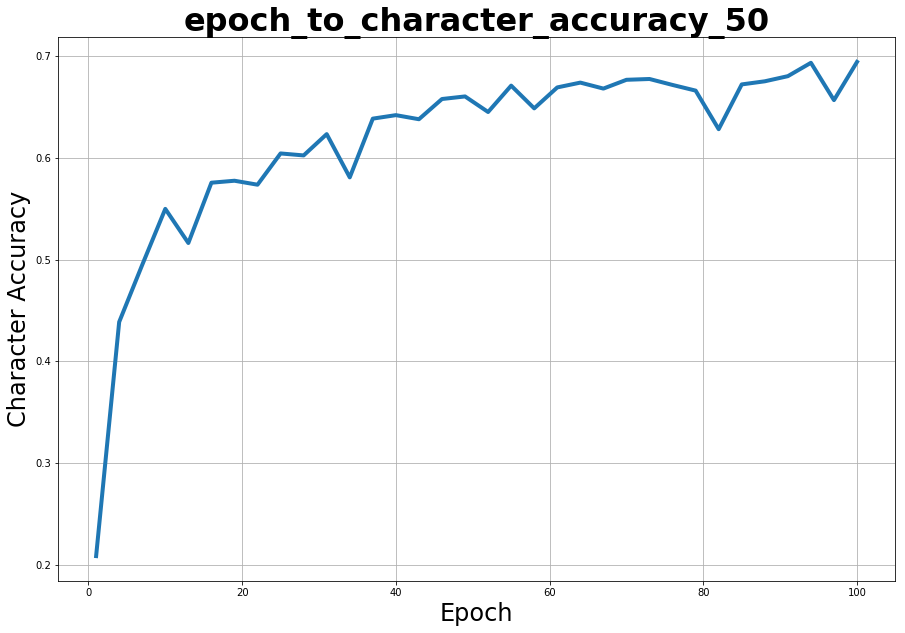

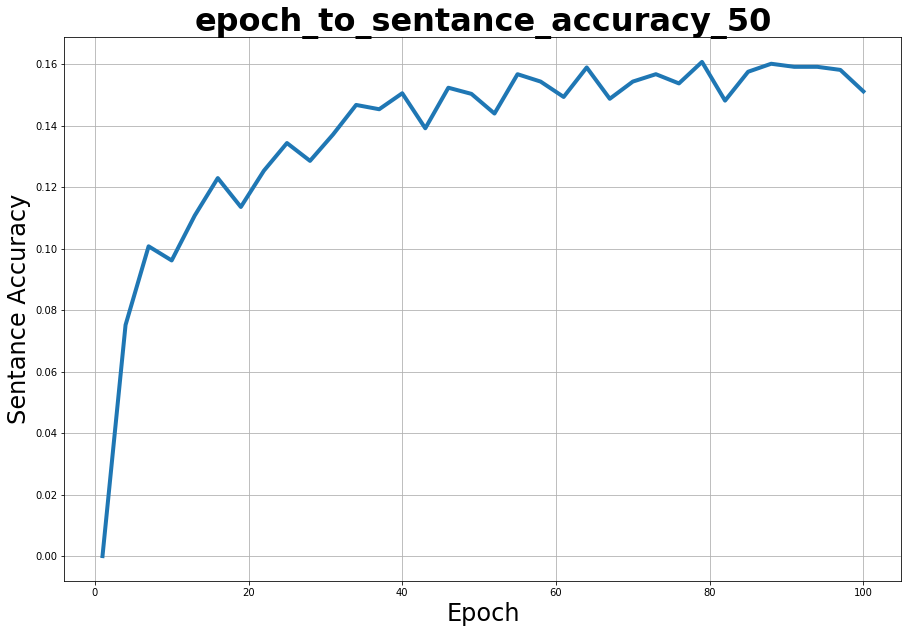

In [36]:
encoder = EncoderRNN(len(pretrain_src.vocab), max_len, hidden_size,
                    bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(pretrain_tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                    dropout_p=0.2, use_attention=None, bidirectional=bidirectional,
                    eos_id=pretrain_tgt.eos_id, sos_id=pretrain_tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=pretrain_loss, batch_size=32,
                    checkpoint_every=50,
                    print_every=100,
                    hidden_size=hidden_size,
                    path="pretrained_rand")
print("pretrain..")

seq2seq, ave_loss, character_accuracy_list, sentance_accuracy_list = t.train(seq2seq, pretrain_train,
                  num_epochs=50, dev_data=pretrain_dev,
                  optimizer=optimizer,
                  teacher_forcing_ratio=0.5)
    
print("train..")
seq2seq, ave_loss, pretrained_character_accuracy_list, pretrained_sentance_accuracy_list = t.train(seq2seq, train,
                                                                            num_epochs=100, dev_data=dev,
                                                                            optimizer=optimizer,
                                                                            teacher_forcing_ratio=0.5)

In [37]:
torch.save(seq2seq.state_dict(), 'log/pth/pretrained_rand_model_save.pth')

- Attention = Luong
- Teacher Forcing Ratio = 0.5
- Layer = 2
- Batch size = 32

2019-02-27 22:26:58,963 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None
2019-02-27 22:28:03,626 INFO   Finished epoch 1: Train loss: 20.1595, Dev loss: 17.7602, Accuracy(Character): 0.1071, Accuracy(Word): 0.0000
2019-02-27 22:29:05,864 INFO   Finished epoch 2: Train loss: 16.1548, Dev loss: 16.1289, Accuracy(Character): 0.1248, Accuracy(Word): 0.0000
2019-02-27 22:30:11,175 INFO   Finished epoch 3: Train loss: 14.8564, Dev loss: 14.2313, Accuracy(Character): 0.1368, Accuracy(Word): 0.0000
2019-02-27 22:31:14,020 INFO   Finished epoch 4: Train loss: 12.2660, Dev loss: 54.1278, Accuracy(Character): 0.1040, Accuracy(Word): 0.0000
2019-02-27 22:32:19,113 INFO   Finished epoch 5: Train loss: 17.3579, Dev loss: 19.1643, Accuracy(Character): 0.1631, Accuracy(Word): 0.0026
2019-02-27 22:33:25,953 INFO   Finished epoch 6: Train loss: 7.9566, Dev loss: 12.7947, Accuracy(Character): 0.2453, 

2019-02-27 23:33:31,700 INFO   Finished epoch 59: Train loss: 1.5250, Dev loss: 1.8021, Accuracy(Character): 0.7664, Accuracy(Word): 0.2210
2019-02-27 23:35:01,591 INFO   Finished epoch 60: Train loss: 1.5328, Dev loss: 1.7580, Accuracy(Character): 0.7832, Accuracy(Word): 0.2014
2019-02-27 23:36:32,414 INFO   Finished epoch 61: Train loss: 1.5971, Dev loss: 1.6918, Accuracy(Character): 0.7871, Accuracy(Word): 0.2108
2019-02-27 23:38:05,253 INFO   Finished epoch 62: Train loss: 1.5146, Dev loss: 1.6543, Accuracy(Character): 0.7863, Accuracy(Word): 0.2236
2019-02-27 23:39:34,892 INFO   Finished epoch 63: Train loss: 1.4772, Dev loss: 1.8330, Accuracy(Character): 0.7532, Accuracy(Word): 0.2020
2019-02-27 23:41:14,241 INFO   Finished epoch 64: Train loss: 1.4475, Dev loss: 1.6540, Accuracy(Character): 0.8070, Accuracy(Word): 0.2010
2019-02-27 23:42:41,201 INFO   Finished epoch 65: Train loss: 1.4577, Dev loss: 1.6100, Accuracy(Character): 0.8132, Accuracy(Word): 0.2168
2019-02-27 23:44:00,

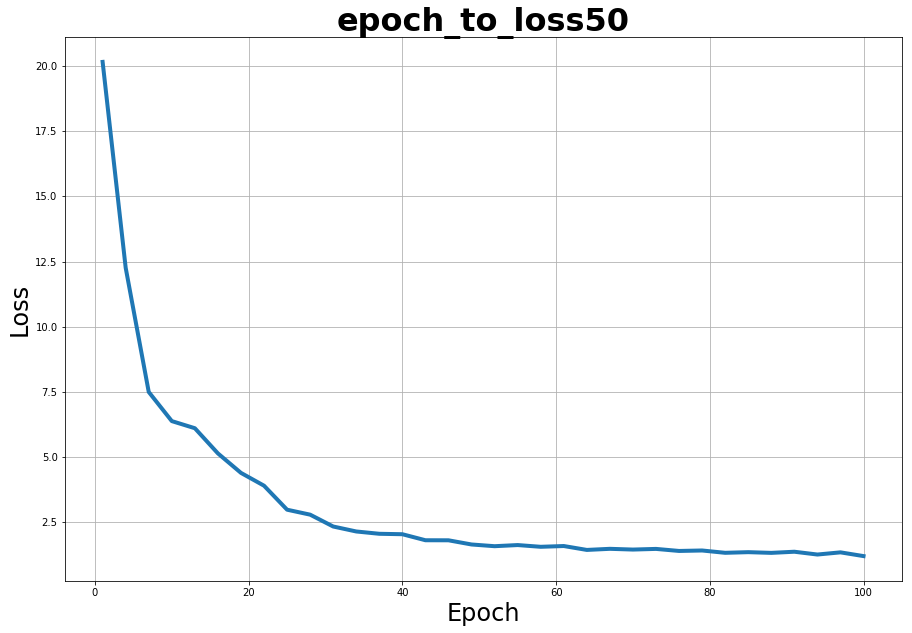

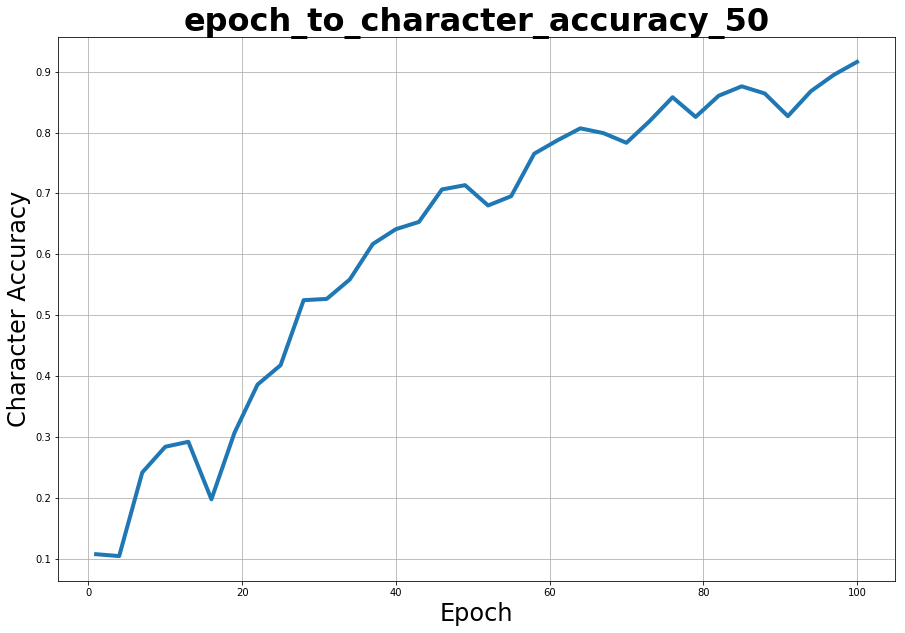

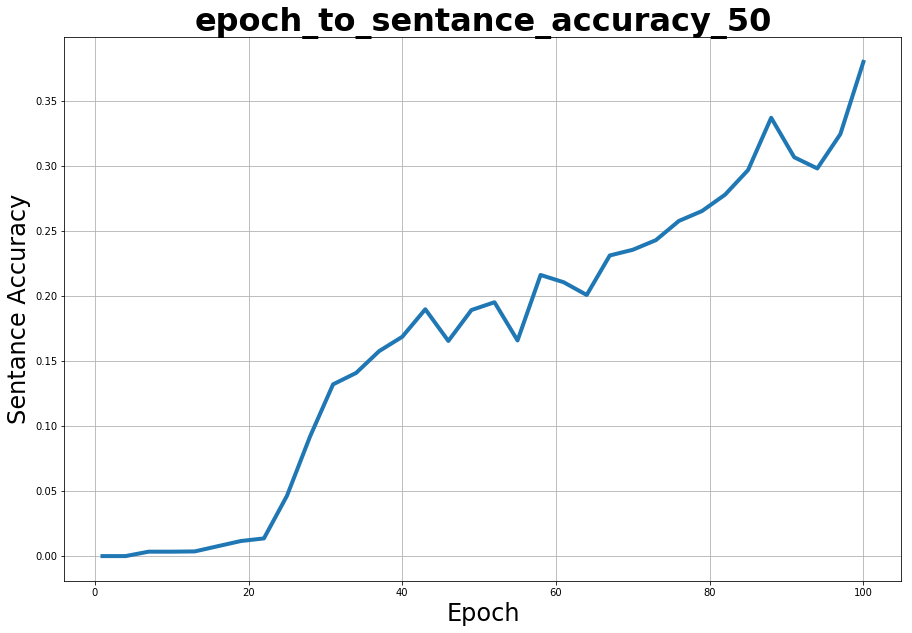

In [39]:
seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size, n_layers=2,
                     bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, n_layers=2, use_attention="Luong", bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=32,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="two_layer_Luong_att_rand")

seq2seq, ave_loss, two_layer_Luong_att_character_accuracy_list, two_layer_Luong_att_sentance_accuracy_list = t.train(seq2seq, train,
                                                                                                            num_epochs=100, dev_data=dev,
                                                                                                            optimizer=optimizer,
                                                                                                            teacher_forcing_ratio=0.5)

In [40]:
torch.save(seq2seq.state_dict(), 'log/pth/two_layer_Luong_att_rand_model_save.pth')

- Attention = Luong
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32
- Pretrained

2019-02-28 00:31:31,046 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


pretrain..


2019-02-28 00:32:26,418 INFO   Finished epoch 1: Train loss: 14.5955, Dev loss: 11.2120, Accuracy(Character): 0.1646, Accuracy(Word): 0.0000
2019-02-28 00:33:21,118 INFO   Finished epoch 2: Train loss: 10.7178, Dev loss: 11.2967, Accuracy(Character): 0.1794, Accuracy(Word): 0.0000
2019-02-28 00:34:19,003 INFO   Finished epoch 3: Train loss: 10.3368, Dev loss: 10.5011, Accuracy(Character): 0.1899, Accuracy(Word): 0.0000
2019-02-28 00:35:14,357 INFO   Finished epoch 4: Train loss: 10.1002, Dev loss: 11.7562, Accuracy(Character): 0.1906, Accuracy(Word): 0.0000
2019-02-28 00:36:09,978 INFO   Finished epoch 5: Train loss: 8.9931, Dev loss: 12.2653, Accuracy(Character): 0.1997, Accuracy(Word): 0.0000
2019-02-28 00:37:04,023 INFO   Finished epoch 6: Train loss: 8.1612, Dev loss: 6.2421, Accuracy(Character): 0.3646, Accuracy(Word): 0.0004
2019-02-28 00:37:59,057 INFO   Finished epoch 7: Train loss: 4.7437, Dev loss: 5.6369, Accuracy(Character): 0.3788, Accuracy(Word): 0.0040
2019-02-28 00:38:5

train..


2019-02-28 01:19:38,488 INFO   Finished epoch 1: Train loss: 705768.7394, Dev loss: 7.6264, Accuracy(Character): 0.2842, Accuracy(Word): 0.0004
2019-02-28 01:21:18,723 INFO   Finished epoch 2: Train loss: 4.6344, Dev loss: 4.8000, Accuracy(Character): 0.4851, Accuracy(Word): 0.0560
2019-02-28 01:23:02,445 INFO   Finished epoch 3: Train loss: 2.7696, Dev loss: 2.8281, Accuracy(Character): 0.6366, Accuracy(Word): 0.1126
2019-02-28 01:24:42,234 INFO   Finished epoch 4: Train loss: 2.1482, Dev loss: 2.8689, Accuracy(Character): 0.6015, Accuracy(Word): 0.1632
2019-02-28 01:26:28,056 INFO   Finished epoch 5: Train loss: 2.0589, Dev loss: 2.2736, Accuracy(Character): 0.6834, Accuracy(Word): 0.1774
2019-02-28 01:28:10,446 INFO   Finished epoch 6: Train loss: 1.8057, Dev loss: 2.0321, Accuracy(Character): 0.7295, Accuracy(Word): 0.1750
2019-02-28 01:29:49,101 INFO   Finished epoch 7: Train loss: 1.7318, Dev loss: 1.9640, Accuracy(Character): 0.7403, Accuracy(Word): 0.2016
2019-02-28 01:31:32,64

2019-02-28 02:59:48,132 INFO   Finished epoch 60: Train loss: 1.0872, Dev loss: 1.1797, Accuracy(Character): 0.9495, Accuracy(Word): 0.4630
2019-02-28 03:01:28,974 INFO   Finished epoch 61: Train loss: 1.1081, Dev loss: 1.1559, Accuracy(Character): 0.9554, Accuracy(Word): 0.4596
2019-02-28 03:03:13,414 INFO   Finished epoch 62: Train loss: 1.1079, Dev loss: 1.1471, Accuracy(Character): 0.9499, Accuracy(Word): 0.4614
2019-02-28 03:04:57,457 INFO   Finished epoch 63: Train loss: 1.0902, Dev loss: 1.1734, Accuracy(Character): 0.9384, Accuracy(Word): 0.4048
2019-02-28 03:06:41,222 INFO   Finished epoch 64: Train loss: 1.0836, Dev loss: 1.1537, Accuracy(Character): 0.9489, Accuracy(Word): 0.5122
2019-02-28 03:08:23,275 INFO   Finished epoch 65: Train loss: 1.0822, Dev loss: 1.1592, Accuracy(Character): 0.9500, Accuracy(Word): 0.4106
2019-02-28 03:10:01,354 INFO   Finished epoch 66: Train loss: 1.0669, Dev loss: 1.1459, Accuracy(Character): 0.9493, Accuracy(Word): 0.3936
2019-02-28 03:11:40,

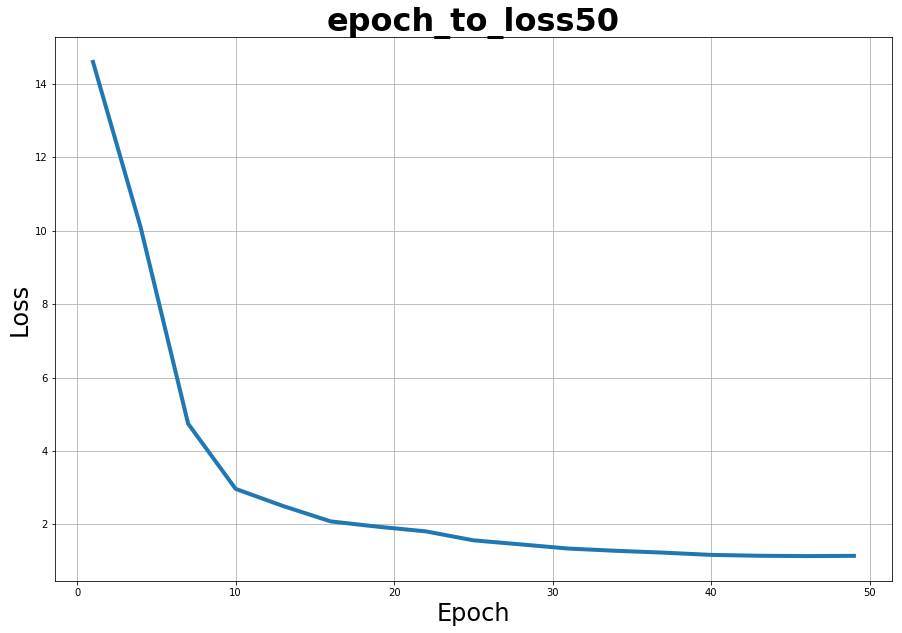

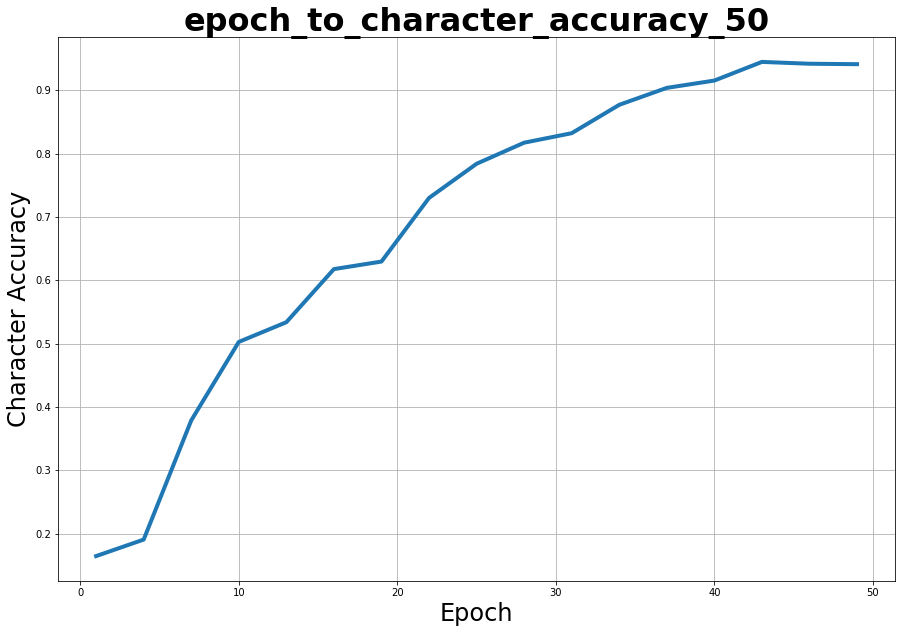

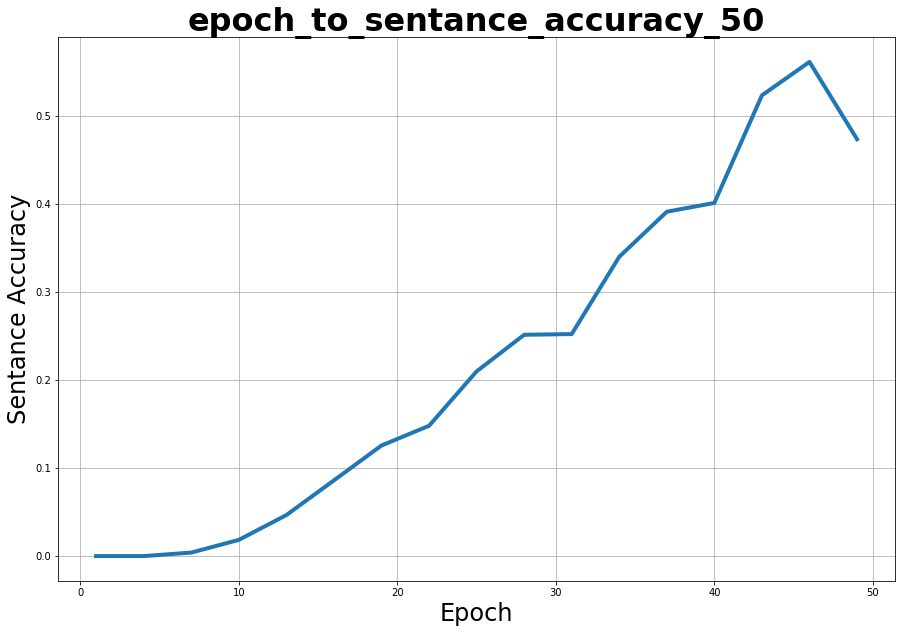

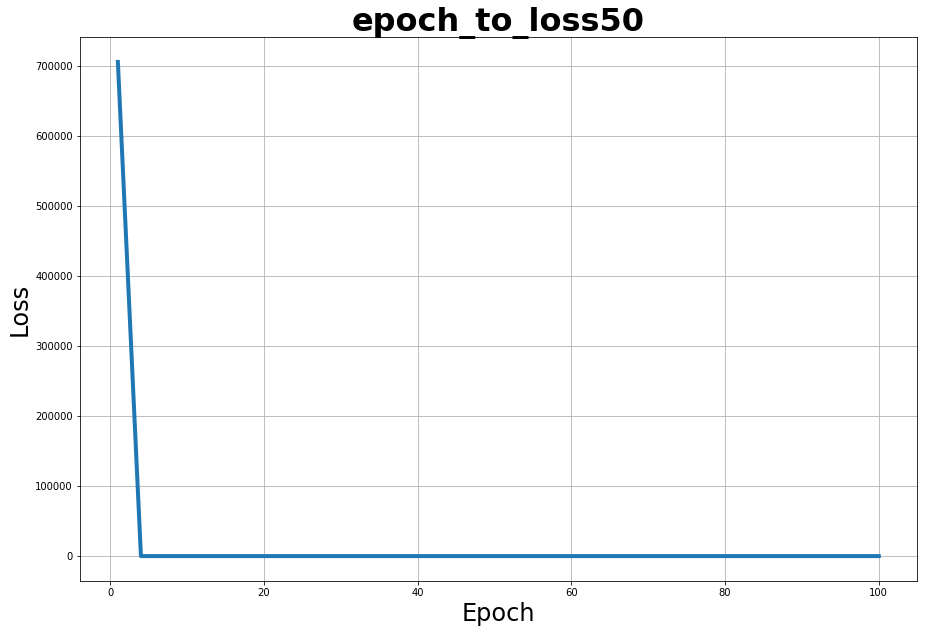

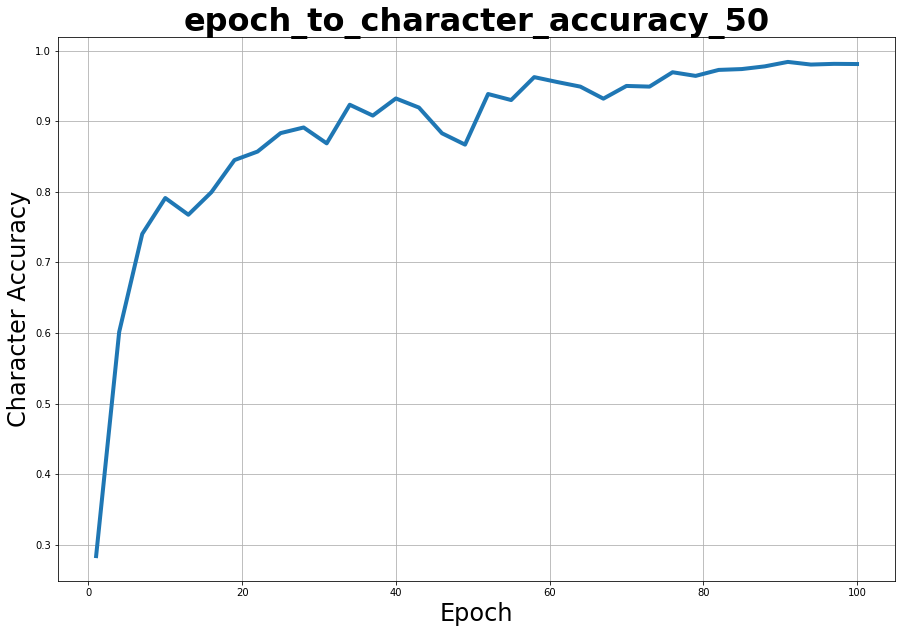

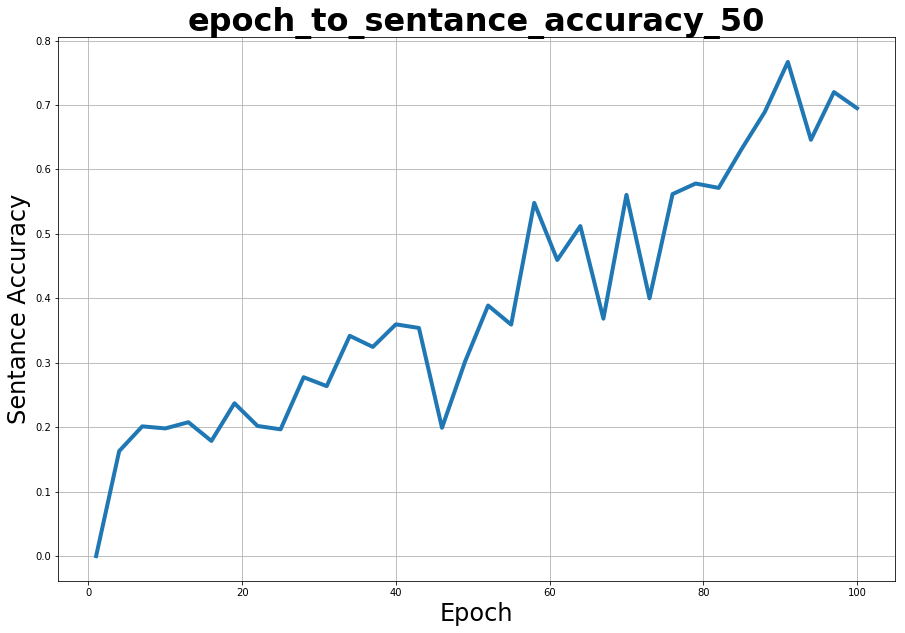

In [41]:
encoder = EncoderRNN(len(pretrain_src.vocab), max_len, hidden_size,
                    bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(pretrain_tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                    dropout_p=0.2, use_attention="Luong", bidirectional=bidirectional,
                    eos_id=pretrain_tgt.eos_id, sos_id=pretrain_tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=pretrain_loss, batch_size=32,
                    checkpoint_every=50,
                    print_every=100,
                    hidden_size=hidden_size,
                    path="pretrained_Luong_att")
print("pretrain..")

seq2seq, ave_loss, character_accuracy_list, sentance_accuracy_list = t.train(seq2seq, pretrain_train,
                  num_epochs=50, dev_data=pretrain_dev,
                  optimizer=optimizer,
                  teacher_forcing_ratio=0.5)
    
print("train..")
seq2seq, ave_loss, pretrained_Luong_att_character_accuracy_list, pretrained_Luong_att_sentance_accuracy_list = t.train(seq2seq, train,
                                                                                                                    num_epochs=100, dev_data=dev,
                                                                                                                    optimizer=optimizer,
                                                                                                                    teacher_forcing_ratio=0.5)

In [42]:
torch.save(seq2seq.state_dict(), 'log/pth/pretrained_Luong_att_model_save.pth')

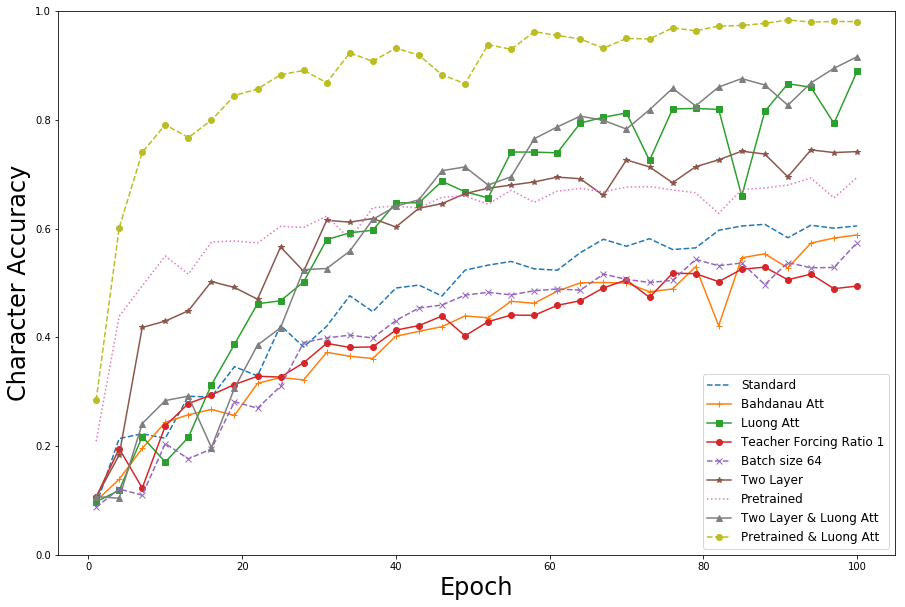

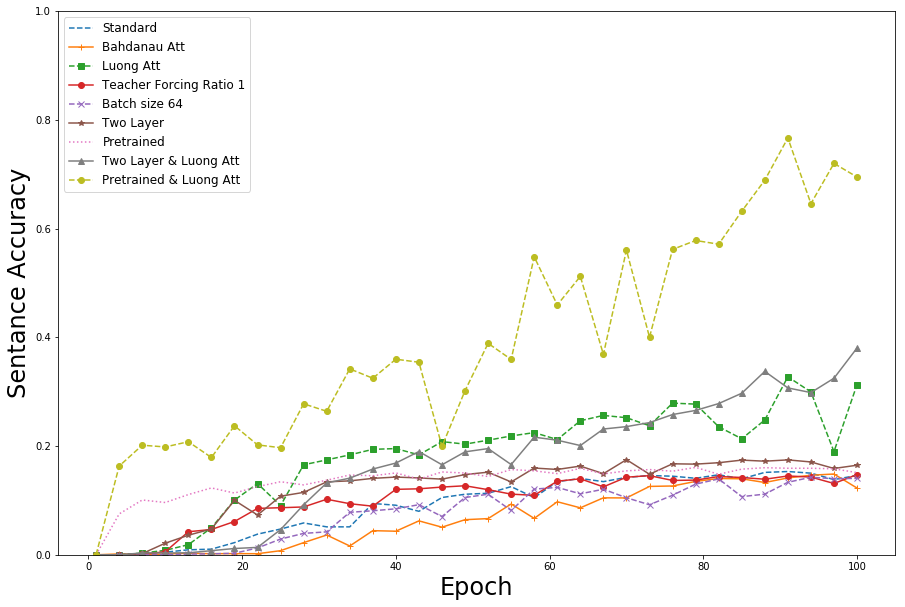

In [44]:
epochs = list(range(1, 101, 1))
plt.figure(figsize=(15,10))
plt.plot(epochs[::3], standard_character_accuracy_list[::3], '--', label="Standard")
plt.plot(epochs[::3], bahdanau_att_character_accuracy_list[::3], '-+', label="Bahdanau Att")
plt.plot(epochs[::3], luong_att_character_accuracy_list[::3], '-s', label="Luong Att")
plt.plot(epochs[::3], tfr_character_accuracy_list[::3], '-o', label="Teacher Forcing Ratio 1")
plt.plot(epochs[::3], batch_size_64_character_accuracy_list[::3], '--x', label="Batch size 64")
plt.plot(epochs[::3], two_layer_character_accuracy_list[::3], '-*', label="Two Layer")
plt.plot(epochs[::3], pretrained_character_accuracy_list[::3], ':', label="Pretrained")
plt.plot(epochs[::3], two_layer_Luong_att_character_accuracy_list[::3], '-^', label="Two Layer & Luong Att")
plt.plot(epochs[::3], pretrained_Luong_att_character_accuracy_list[::3], '--o', label="Pretrained & Luong Att")
plt.legend(loc="best", fontsize=12)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Character Accuracy', fontsize=24)
plt.ylim([0, 1])
plt.savefig('log/plot/parameter_to_accuracy/bracket_epoch_to_character_accuracy.png')

plt.figure(figsize=(15,10))
plt.plot(epochs[::3], standard_sentance_accuracy_list[::3], '--', label="Standard")
plt.plot(epochs[::3], bahdanau_att_sentance_accuracy_list[::3], '-+', label="Bahdanau Att")
plt.plot(epochs[::3], luong_att_sentance_accuracy_list[::3], '--s', label="Luong Att")
plt.plot(epochs[::3], tfr_sentance_accuracy_list[::3], '-o', label="Teacher Forcing Ratio 1")
plt.plot(epochs[::3], batch_size_64_sentance_accuracy_list[::3], '--x', label="Batch size 64")
plt.plot(epochs[::3], two_layer_sentance_accuracy_list[::3], '-*',label="Two Layer")
plt.plot(epochs[::3], pretrained_sentance_accuracy_list[::3], ':', label="Pretrained")
plt.plot(epochs[::3], two_layer_Luong_att_sentance_accuracy_list[::3], '-^', label="Two Layer & Luong Att")
plt.plot(epochs[::3], pretrained_Luong_att_sentance_accuracy_list[::3], '--o', label="Pretrained & Luong Att")
plt.legend(loc="best", fontsize=12)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Sentance Accuracy', fontsize=24)
plt.ylim([0, 1])
plt.savefig('log/plot/parameter_to_accuracy/bracket_epoch_to_sentance_accuracy.png')

In [45]:
print(standard_character_accuracy_list)
print(bahdanau_att_character_accuracy_list)
print(luong_att_character_accuracy_list)
print(tfr_character_accuracy_list)
print(batch_size_64_character_accuracy_list)
print(two_layer_character_accuracy_list)
print(pretrained_character_accuracy_list)
print(two_layer_Luong_att_character_accuracy_list)
print(pretrained_Luong_att_character_accuracy_list)

[0.09101985587196239, 0.09710886748669846, 0.1394472438727216, 0.21390523306005743, 0.16102665205385516, 0.22981503364416173, 0.22269434937273078, 0.2386531314479541, 0.23735206059010452, 0.21439198662805292, 0.2360571124186448, 0.2675981313561138, 0.2914674242470626, 0.2255444598872201, 0.31526018355813795, 0.29060106412289455, 0.3783054853147367, 0.30084125710996956, 0.34613076833591505, 0.359753745553399, 0.3769278808770136, 0.3291648043495564, 0.40683108120518957, 0.4195999436712852, 0.42191125778346505, 0.42114286064153506, 0.4252756739547044, 0.38230666087052356, 0.4493990583308332, 0.47418063149387424, 0.4203530340972405, 0.4356811794743061, 0.46102603978521617, 0.4765899085882922, 0.45574828411713925, 0.4746122808843608, 0.44719795257367123, 0.48327282078284667, 0.4852688165459477, 0.4907639275808654, 0.5072768127743729, 0.49896832734330515, 0.49621005712466404, 0.5006826795324717, 0.5230121167963656, 0.47605417352917767, 0.528571516038377, 0.47833793555260307, 0.52359071066020

In [46]:
print(standard_sentance_accuracy_list)
print(bahdanau_att_sentance_accuracy_list)
print(luong_att_sentance_accuracy_list)
print(tfr_sentance_accuracy_list)
print(batch_size_64_sentance_accuracy_list)
print(two_layer_sentance_accuracy_list)
print(pretrained_sentance_accuracy_list)
print(two_layer_Luong_att_sentance_accuracy_list)
print(pretrained_Luong_att_sentance_accuracy_list)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0026, 0.0024, 0.001, 0.0046, 0.0048, 0.0084, 0.0036, 0.0092, 0.0046, 0.006, 0.0104, 0.0156, 0.0236, 0.0224, 0.0344, 0.036, 0.038, 0.0398, 0.0404, 0.0474, 0.048, 0.051, 0.0586, 0.056, 0.0498, 0.0514, 0.0792, 0.0712, 0.0514, 0.0696, 0.088, 0.0944, 0.0622, 0.0932, 0.0912, 0.1038, 0.1058, 0.08, 0.105, 0.1076, 0.1054, 0.1056, 0.1084, 0.1114, 0.1208, 0.1108, 0.1132, 0.1128, 0.1094, 0.1254, 0.1304, 0.1318, 0.1052, 0.1358, 0.1302, 0.1346, 0.1364, 0.1308, 0.1404, 0.1392, 0.1348, 0.1346, 0.1398, 0.142, 0.1424, 0.1332, 0.1438, 0.1458, 0.1372, 0.1482, 0.1446, 0.1372, 0.1526, 0.1408, 0.1528, 0.143, 0.1472, 0.1506, 0.15, 0.1398, 0.1424, 0.144, 0.1516, 0.1486, 0.1424, 0.1532, 0.1494, 0.156, 0.1502, 0.15, 0.1542, 0.1384, 0.1506, 0.1564, 0.146]
[0.0, 0.0, 0.0, 0.0016, 0.0, 0.0, 0.0, 0.0, 0.0022, 0.0014, 0.0032, 0.005, 0.0028, 0.0014, 0.0032, 0.002, 0.0014, 0.0022, 0.0022, 0.0024, 0.003, 0.002, 0.001, 0.0036, 0.0076, 0.0028, 0.0056, 0.0224, 0.0186, 0.0176, 0.0364, 0.0284, 0.0